# Assignment 2

In [1]:
import os
import os.path
import random

import numpy as np
import pandas as pd
from typing import Dict, List
import torch
#import torch.nn as nn
#import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import tensorflow as tf

# 1. Load Data

In [2]:
# Set TensorFlow logging level to suppress unnecessary output
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.get_logger().setLevel('ERROR')

# Helper function: Load embeddings from TFRecord files
def load_embedding(embedding_path):
    raw_dataset = tf.data.TFRecordDataset([embedding_path])
    for raw_record in raw_dataset.take(1):
        example = tf.train.Example()
        example.ParseFromString(raw_record.numpy())
        embedding_feature = example.features.feature['embedding']
        embedding_values = embedding_feature.float_list.value
    embedding = torch.tensor(embedding_values)
    if torch.isnan(embedding).any() or torch.isinf(embedding).any():
        raise ValueError(f"NaN or Inf found in embedding: {embedding_path}")
    return embedding

# Custom dataset class for MIMIC chest X-ray embeddings
class MIMIC_Embed_Dataset(Dataset):
    pathologies = [
        "Enlarged Cardiomediastinum", "Cardiomegaly", "Lung Opacity", "Lung Lesion",
        "Edema", "Consolidation", "Pneumonia", "Atelectasis", "Pneumothorax",
        "Pleural Effusion", "Pleural Other", "Fracture", "Support Devices"
    ]

    def __init__(self, embedpath, csvpath, metacsvpath, views=["PA"], mode="train", seed=42, split_ratio=[0.5, 0.3, 0.2], unique_patients=True):
        super().__init__()
        np.random.seed(seed)  # Set seed for reproducibility
        self.pathologies = sorted(self.pathologies)
        self.mode = mode
        self.embedpath = embedpath
        self.csv = pd.read_csv(csvpath)
        self.metacsv = pd.read_csv(metacsvpath)
        self.split_ratio = split_ratio

        # Merge CSV data
        self.csv = self.csv.set_index(["subject_id", "study_id"])
        self.metacsv = self.metacsv.set_index(["subject_id", "study_id"])
        self.csv = self.csv.join(self.metacsv).reset_index()

        self.csv["view"] = self.csv["ViewPosition"]
        self.limit_to_selected_views(views)

        if unique_patients:
            self.csv = self.csv.groupby("subject_id").first().reset_index()

        # Split dataset into train, validation, and test sets
        n_row = self.csv.shape[0]
        if self.mode == "train":
            self.csv = self.csv[:int(n_row * self.split_ratio[0])]
        elif self.mode == "valid":
            self.csv = self.csv[int(n_row * self.split_ratio[0]):int(n_row * (self.split_ratio[0] + self.split_ratio[1]))]
        elif self.mode == "test":
            self.csv = self.csv[int(n_row * (self.split_ratio[0] + self.split_ratio[1])):]
        else:
            raise ValueError(f"mode must be one of [train, valid, test], got {self.mode}")

        # Process labels
        healthy = self.csv["No Finding"] == 1
        labels = []
        for pathology in self.pathologies:
            if pathology in self.csv.columns:
                self.csv.loc[healthy, pathology] = 0
                mask = self.csv[pathology]
            labels.append(mask.values)
        self.labels = np.asarray(labels).T.astype(np.float32)
        self.labels[np.isnan(self.labels)] = 0  # Replace all NaN values with 0
        self.labels = np.where((self.labels != 0) & (self.labels != 1), 0, self.labels)

        self.csv = self.csv.reset_index(drop=True)
        self.pathologies = list(np.char.replace(self.pathologies, "Pleural Effusion", "Effusion"))
        self.csv["offset_day_int"] = self.csv["StudyDate"]
        self.csv["patientid"] = self.csv["subject_id"].astype(str)

    def limit_to_selected_views(self, views):
        # Limit dataset to specified views
        if not isinstance(views, list):
            views = [views]
        if '*' in views:
            views = ["*"]
        self.views = views
        self.csv["view"] = self.csv["view"].fillna("UNKNOWN")
        if "*" not in views:
            self.csv = self.csv[self.csv["view"].isin(self.views)]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # Retrieve a single sample from the dataset
        sample = {}
        sample["idx"] = idx
        sample["lab"] = self.labels[idx]
        subjectid = str(self.csv.iloc[idx]["subject_id"])
        studyid = str(self.csv.iloc[idx]["study_id"])
        dicom_id = str(self.csv.iloc[idx]["dicom_id"])
        embed_file = os.path.join(self.embedpath, f"p{subjectid[:2]}", f"p{subjectid}", f"s{studyid}", f"{dicom_id}.tfrecord")
        sample["embedding"] = load_embedding(embed_file)
        return sample

# Function to initialize datasets with given paths, seed, and split ratio
def initialize_mimic_datasets(embedpath, csvpath, metacsvpath, seed=42, split_ratio=[0.5, 0.3, 0.2]):
    """
    Initialize MIMIC chest X-ray datasets with specified paths, seed, and split ratio.
    
    Args:
        embedpath (str): Path to the embedding files
        csvpath (str): Path to the CheXpert CSV file
        metacsvpath (str): Path to the metadata CSV file
        seed (int): Random seed for reproducibility (default: 42)
        split_ratio (list): Train, validation, test split ratio (default: [0.5, 0.3, 0.2])
    
    Returns:
        tuple: (train_dataset, val_dataset, test_dataset)
    """
    train_dataset = MIMIC_Embed_Dataset(
        embedpath=embedpath,
        csvpath=csvpath,
        metacsvpath=metacsvpath,
        mode="train",
        seed=seed,
        split_ratio=split_ratio
    )
    val_dataset = MIMIC_Embed_Dataset(
        embedpath=embedpath,
        csvpath=csvpath,
        metacsvpath=metacsvpath,
        mode="valid",
        seed=seed,
        split_ratio=split_ratio
    )
    test_dataset = MIMIC_Embed_Dataset(
        embedpath=embedpath,
        csvpath=csvpath,
        metacsvpath=metacsvpath,
        mode="test",
        seed=seed,
        split_ratio=split_ratio
    )
    return train_dataset, val_dataset, test_dataset

# Data paths
embedpath = "C:/Users/shery/Downloads/assignment2/generalized-image-embeddings-for-the-mimic-chest-x-ray-dataset-1.0/files"
csvpath = "C:/Users/shery/Downloads/assignment2/mimic-cxr-2.0.0-chexpert.csv"
metacsvpath = "C:/Users/shery/Downloads/assignment2/mimic-cxr-2.0.0-metadata.csv"

train_dataset, val_dataset, test_dataset = initialize_mimic_datasets(
    embedpath=embedpath,
    csvpath=csvpath,
    metacsvpath=metacsvpath,
    seed=42,
    split_ratio=[0.5, 0.3, 0.2]
)

In [3]:
sampletr = train_dataset[1000]
sampletr

{'idx': 1000,
 'lab': array([0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0.], dtype=float32),
 'embedding': tensor([-0.6009, -2.6448,  1.1589,  ...,  0.3574,  1.4271, -2.1083])}

In [4]:
samplev = val_dataset[1000]
samplev

{'idx': 1000,
 'lab': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32),
 'embedding': tensor([ 0.0728, -1.7532,  0.8360,  ..., -0.7722,  0.8441, -0.5825])}

In [5]:
samplete = test_dataset[1000]
samplete

{'idx': 1000,
 'lab': array([1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.], dtype=float32),
 'embedding': tensor([-0.5893, -1.4492,  1.0979,  ..., -0.6514,  1.0990, -0.9476])}

## Train model

In [11]:
# Skopt functions
from skopt import BayesSearchCV
from skopt.callbacks import DeadlineStopper, DeltaYStopper
from skopt.space import Real, Categorical, Integer
from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV, KFold
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import make_scorer,log_loss
from xgboost import XGBClassifier
import pickle
import joblib

In [12]:
# Initialize XGBoost wrapped in MultiOutputClassifier
XGBoostModel = MultiOutputClassifier(
    XGBClassifier(
        objective='binary:logistic',  # Treat each label as a binary problem
        tree_method="hist",
        eval_metric='logloss'
    )
)

# Use KFold instead of StratifiedKFold for multilabel classification
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Custom scorer for MultiOutputClassifier
def multi_label_log_loss(y_true, y_pred_proba):

    # Convert list of arrays into a single NumPy array (shape: n_samples x n_labels)
    y_pred_proba_arr = np.array([proba[:, 1] if proba.ndim == 2 else proba for proba in y_pred_proba])
    
    # Check dimensions
    if y_true.shape != y_pred_proba_arr.shape:
        y_pred_proba_arr=y_pred_proba_arr.T
        #raise ValueError(f"Shape mismatch: y_true {y_true.shape} vs y_pred_proba_arr {y_pred_proba_arr.shape}")
    
    # Compute log loss for each label
    losses = []
    for i in range(y_true.shape[1]):
        loss = log_loss(y_true[:, i], y_pred_proba_arr[:, i])  # Compute log loss for label i
        #print(loss)
        losses.append(loss)
    return np.mean(losses)  # Return mean log loss across all labels

# Wrap the custom scorer using make_scorer
scorer = make_scorer(multi_label_log_loss, response_method="predict_proba")


In [13]:
parameters = {
    'estimator__max_depth': [3, 5, 7],
    'estimator__learning_rate': [0.01, 0.1, 0.2],
    'estimator__n_estimators': [50, 100, 150]
}

# Perform GridSearchCV with custom scorer to minimize log loss
BestXGBoost = GridSearchCV(
    estimator=XGBoostModel,
    param_grid=parameters,
    scoring=scorer,
    error_score='raise',
    cv=cv,
    verbose=1,
    n_jobs=-1  # Use all CPU cores to speed up grid search
)

In [14]:
# Initialize XGBoost wrapped in MultiOutputClassifier
XGBoostModel = MultiOutputClassifier(
    XGBClassifier(
        objective='binary:logistic',  # Treat each label as a binary problem
        tree_method="hist",
        eval_metric='logloss'
    )
)

# Use KFold instead of StratifiedKFold for multilabel classification
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Custom scorer for MultiOutputClassifier
def multi_label_log_loss(y_true, y_pred_proba):

    # Convert list of arrays into a single NumPy array (shape: n_samples x n_labels)
    y_pred_proba_arr = np.array([proba[:, 1] if proba.ndim == 2 else proba for proba in y_pred_proba])
    
    # Check dimensions
    if y_true.shape != y_pred_proba_arr.shape:
        y_pred_proba_arr=y_pred_proba_arr.T
        #raise ValueError(f"Shape mismatch: y_true {y_true.shape} vs y_pred_proba_arr {y_pred_proba_arr.shape}")
    
    # Compute log loss for each label
    losses = []
    for i in range(y_true.shape[1]):
        loss = log_loss(y_true[:, i], y_pred_proba_arr[:, i])  # Compute log loss for label i
        #print(loss)
        losses.append(loss)
    return np.mean(losses)  # Return mean log loss across all labels

# Wrap the custom scorer using make_scorer
scorer = make_scorer(multi_label_log_loss, response_method="predict_proba")

# Perform GridSearchCV with custom scorer to minimize log loss
BestXGBoost = GridSearchCV(
    estimator=XGBoostModel,
    param_grid=parameters,
    scoring=scorer,
    error_score='raise',
    cv=cv,
    verbose=1,
    n_jobs=-1  # Use all CPU cores to speed up grid search
)

In [15]:
def train_model(x_train, y_train,groupname):
    
    model = BestXGBoost.fit(x_train,y_train)
    print("end model")

    y_train_pred = model.predict_proba(x_train)
    loss_train = multi_label_log_loss(y_train, y_train_pred)
    print(f"Training loss: {loss_train}")
    
    print(model.best_params_)
    print(model.best_score_)
    print(loss_train)

    joblib.dump(model, f"model_xgb_{groupname}_v2.pkl")

    return model

In [11]:
x_train = np.stack([sample['embedding'].numpy() for sample in train_dataset])  # shape: [n_samples, embedding_dim]
y_train = np.stack([sample['lab'] for sample in train_dataset]) # shape: [n_samples, n_labels]  
print(x_train.shape)
print(y_train.shape)

(22814, 1376)
(22814, 13)


In [12]:
model_train = train_model(x_train,y_train,"all")

Fitting 5 folds for each of 27 candidates, totalling 135 fits
end model
Training loss: 0.0026248548122330107
{'estimator__learning_rate': 0.2, 'estimator__max_depth': 7, 'estimator__n_estimators': 150}
0.19391009179657118
0.0026248548122330107


# Validate model

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

def gen_pred_lab(y_true,y_pred,threshold=0.5):
    n_labels = y_true.shape[1]
    pred_lab = []

    for i in range(n_labels):
            probs = y_pred[i][:, 1]  # class 1 probability
            y_p = (probs >= threshold).astype(int)
            pred_lab.append(y_p)
    return pred_lab


# Calculate basic metrics
def calculate_metrics(predictions, labels, pathologies):
    metrics = {}
    for i, pathology in enumerate(pathologies):
        tn, fp, fn, tp = confusion_matrix(labels[:, i], predictions[:, i]).ravel()
        accuracy = (tp + tn) / (tp + tn + fp + fn)
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        
        metrics[pathology] = {
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1-score': f1
        }
    return metrics

# Function to plot confusion matrix for each pathology with fixed visualization
def plot_confusion_matrices(predictions, labels, pathologies):
    # Set up the figure with a grid layout
    n_pathologies = len(pathologies)
    n_cols = 4
    n_rows = (n_pathologies + n_cols - 1) // n_cols  # Ceiling division
    plt.figure(figsize=(n_cols * 5, n_rows * 6))  # Increase height to accommodate second row
    
    for i, pathology in enumerate(pathologies):
        # Calculate confusion matrix
        cm = confusion_matrix(labels[:, i], predictions[:, i])
        
        # Create subplot
        plt.subplot(n_rows, n_cols, i + 1)
        
        # Plot heatmap with new colormap 'YlOrRd'
        sns.heatmap(cm, annot=True, fmt='d', cmap='YlOrRd', cbar=False,
                    annot_kws={"size": 12}, square=True,
                    vmin=0, vmax=np.max(cm))  # Set vmin and vmax to control color scaling
        
        # Set labels and title
        plt.title(f'Confusion Matrix: {pathology}', fontsize=12, pad=20)
        plt.ylabel('True Label', fontsize=10)
        plt.xlabel('Predicted Label', fontsize=10)
        
        # Set tick labels
        plt.xticks([0.5, 1.5], ['0', '1'])
        plt.yticks([0.5, 1.5], ['0', '1'], rotation=0)
    
    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()

# Function to calculate and print confusion matrix data for each pathology
def print_confusion_matrices(predictions, labels, pathologies):
    print("\nConfusion Matrices for Each Pathology:")
    for i, pathology in enumerate(pathologies):
        cm = confusion_matrix(labels[:, i], predictions[:, i])
        print(f"\n{pathology}:")
        print("[[True Negative, False Positive]")
        print(" [False Negative, True Positive]]")
        print(cm)
        #cr=classification_report(labels[:, i], predictions[:, i],target_names=pathology))
        #print(cr)

In [7]:
def validate_model(model,data_validation,x_val,y_val_true):
    y_val_pred = model.predict_proba(x_val)
    loss_val = multi_label_log_loss(y_val_true, y_val_pred)
    print(f"Validation loss: {loss_val}")

    y_val_pred_lab = gen_pred_lab(y_val_true, y_val_pred)
    y_val_pred_lab = np.array(y_val_pred_lab).T
    print(y_val_pred_lab.shape)
    print(y_val_pred_lab[0,:])

    pathologies=data_validation.pathologies

    # Calculate and print metrics
    metrics = calculate_metrics(y_val_pred_lab, y_val_true, pathologies)
    print("\nModel Performance Metrics:")
    for pathology, metric in metrics.items():
        print(f"\n{pathology}:")
        for metric_name, value in metric.items():
            print(f"{metric_name}: {value:.4f}")

    print_confusion_matrices(y_val_pred_lab, y_val_true, pathologies)
    plot_confusion_matrices(y_val_pred_lab, y_val_true, pathologies)
    print(classification_report(y_val_true,y_val_pred_lab, target_names=pathologies,zero_division=0))

In [8]:
x_valid = np.stack([sample['embedding'].numpy() for sample in val_dataset])  # shape: [n_samples, embedding_dim]
y_valid = np.stack([sample['lab'] for sample in val_dataset]) # shape: [n_samples, n_labels]  
print(x_valid.shape)
print(y_valid.shape)

(13688, 1376)
(13688, 13)


In [16]:
import joblib
model_train = joblib.load("model_xgb_all_v2.pkl")

validate_model(model_train,val_dataset,x_valid,y_valid)

Validation loss: 0.18825603698389634
(13688, 13)
[0 0 0 0 0 0 0 0 0 0 0 0 0]

Model Performance Metrics:

Atelectasis:
Accuracy: 0.9110
Precision: 0.4899
Recall: 0.1404
F1-score: 0.2182

Cardiomegaly:
Accuracy: 0.9215
Precision: 0.5147
Recall: 0.1613
F1-score: 0.2456

Consolidation:
Accuracy: 0.9821
Precision: 0.3333
Recall: 0.0082
F1-score: 0.0161

Edema:
Accuracy: 0.9736
Precision: 0.4681
Recall: 0.1236
F1-score: 0.1956

Enlarged Cardiomediastinum:
Accuracy: 0.9862
Precision: 0.0000
Recall: 0.0000
F1-score: 0.0000

Fracture:
Accuracy: 0.9789
Precision: 1.0000
Recall: 0.0103
F1-score: 0.0203

Lung Lesion:
Accuracy: 0.9714
Precision: 0.5000
Recall: 0.0128
F1-score: 0.0249

Lung Opacity:
Accuracy: 0.8791
Precision: 0.4566
Recall: 0.1402
F1-score: 0.2145

Effusion:
Accuracy: 0.9368
Precision: 0.6850
Recall: 0.4228
F1-score: 0.5229

Pleural Other:
Accuracy: 0.9909
Precision: 0.2500
Recall: 0.0081
F1-score: 0.0157

Pneumonia:
Accuracy: 0.9504
Precision: 0.5417
Recall: 0.0569
F1-score: 0.10

                            precision    recall  f1-score   support

               Atelectasis       0.49      0.14      0.22      1211
              Cardiomegaly       0.51      0.16      0.25      1085
             Consolidation       0.33      0.01      0.02       243
                     Edema       0.47      0.12      0.20       356
Enlarged Cardiomediastinum       0.00      0.00      0.00       189
                  Fracture       1.00      0.01      0.02       292
               Lung Lesion       0.50      0.01      0.02       392
              Lung Opacity       0.46      0.14      0.21      1612
                  Effusion       0.68      0.42      0.52      1121
             Pleural Other       0.25      0.01      0.02       123
                 Pneumonia       0.54      0.06      0.10       685
              Pneumothorax       0.48      0.06      0.11       175
           Support Devices       0.49      0.13      0.21       572

                 micro avg       0.55      0.1

## Test model

In [17]:
x_test = np.stack([sample['embedding'].numpy() for sample in test_dataset])  # shape: [n_samples, embedding_dim]
y_test = np.stack([sample['lab'] for sample in test_dataset]) # shape: [n_samples, n_labels]  
print(x_test.shape)
print(y_test.shape)

(9126, 1376)
(9126, 13)


Validation loss: 0.189895293927993
(9126, 13)
[0 0 0 0 0 0 0 0 0 0 0 0 0]

Model Performance Metrics:

Atelectasis:
Accuracy: 0.9061
Precision: 0.4962
Recall: 0.1520
F1-score: 0.2328

Cardiomegaly:
Accuracy: 0.9192
Precision: 0.5541
Recall: 0.1616
F1-score: 0.2503

Consolidation:
Accuracy: 0.9818
Precision: 0.0000
Recall: 0.0000
F1-score: 0.0000

Edema:
Accuracy: 0.9744
Precision: 0.4648
Recall: 0.1441
F1-score: 0.2200

Enlarged Cardiomediastinum:
Accuracy: 0.9848
Precision: 0.0000
Recall: 0.0000
F1-score: 0.0000

Fracture:
Accuracy: 0.9797
Precision: 0.0000
Recall: 0.0000
F1-score: 0.0000

Lung Lesion:
Accuracy: 0.9704
Precision: 0.6000
Recall: 0.0111
F1-score: 0.0217

Lung Opacity:
Accuracy: 0.8765
Precision: 0.4884
Recall: 0.1313
F1-score: 0.2069

Effusion:
Accuracy: 0.9336
Precision: 0.6293
Recall: 0.4461
F1-score: 0.5221

Pleural Other:
Accuracy: 0.9910
Precision: 0.0000
Recall: 0.0000
F1-score: 0.0000

Pneumonia:
Accuracy: 0.9536
Precision: 0.6111
Recall: 0.0510
F1-score: 0.0942


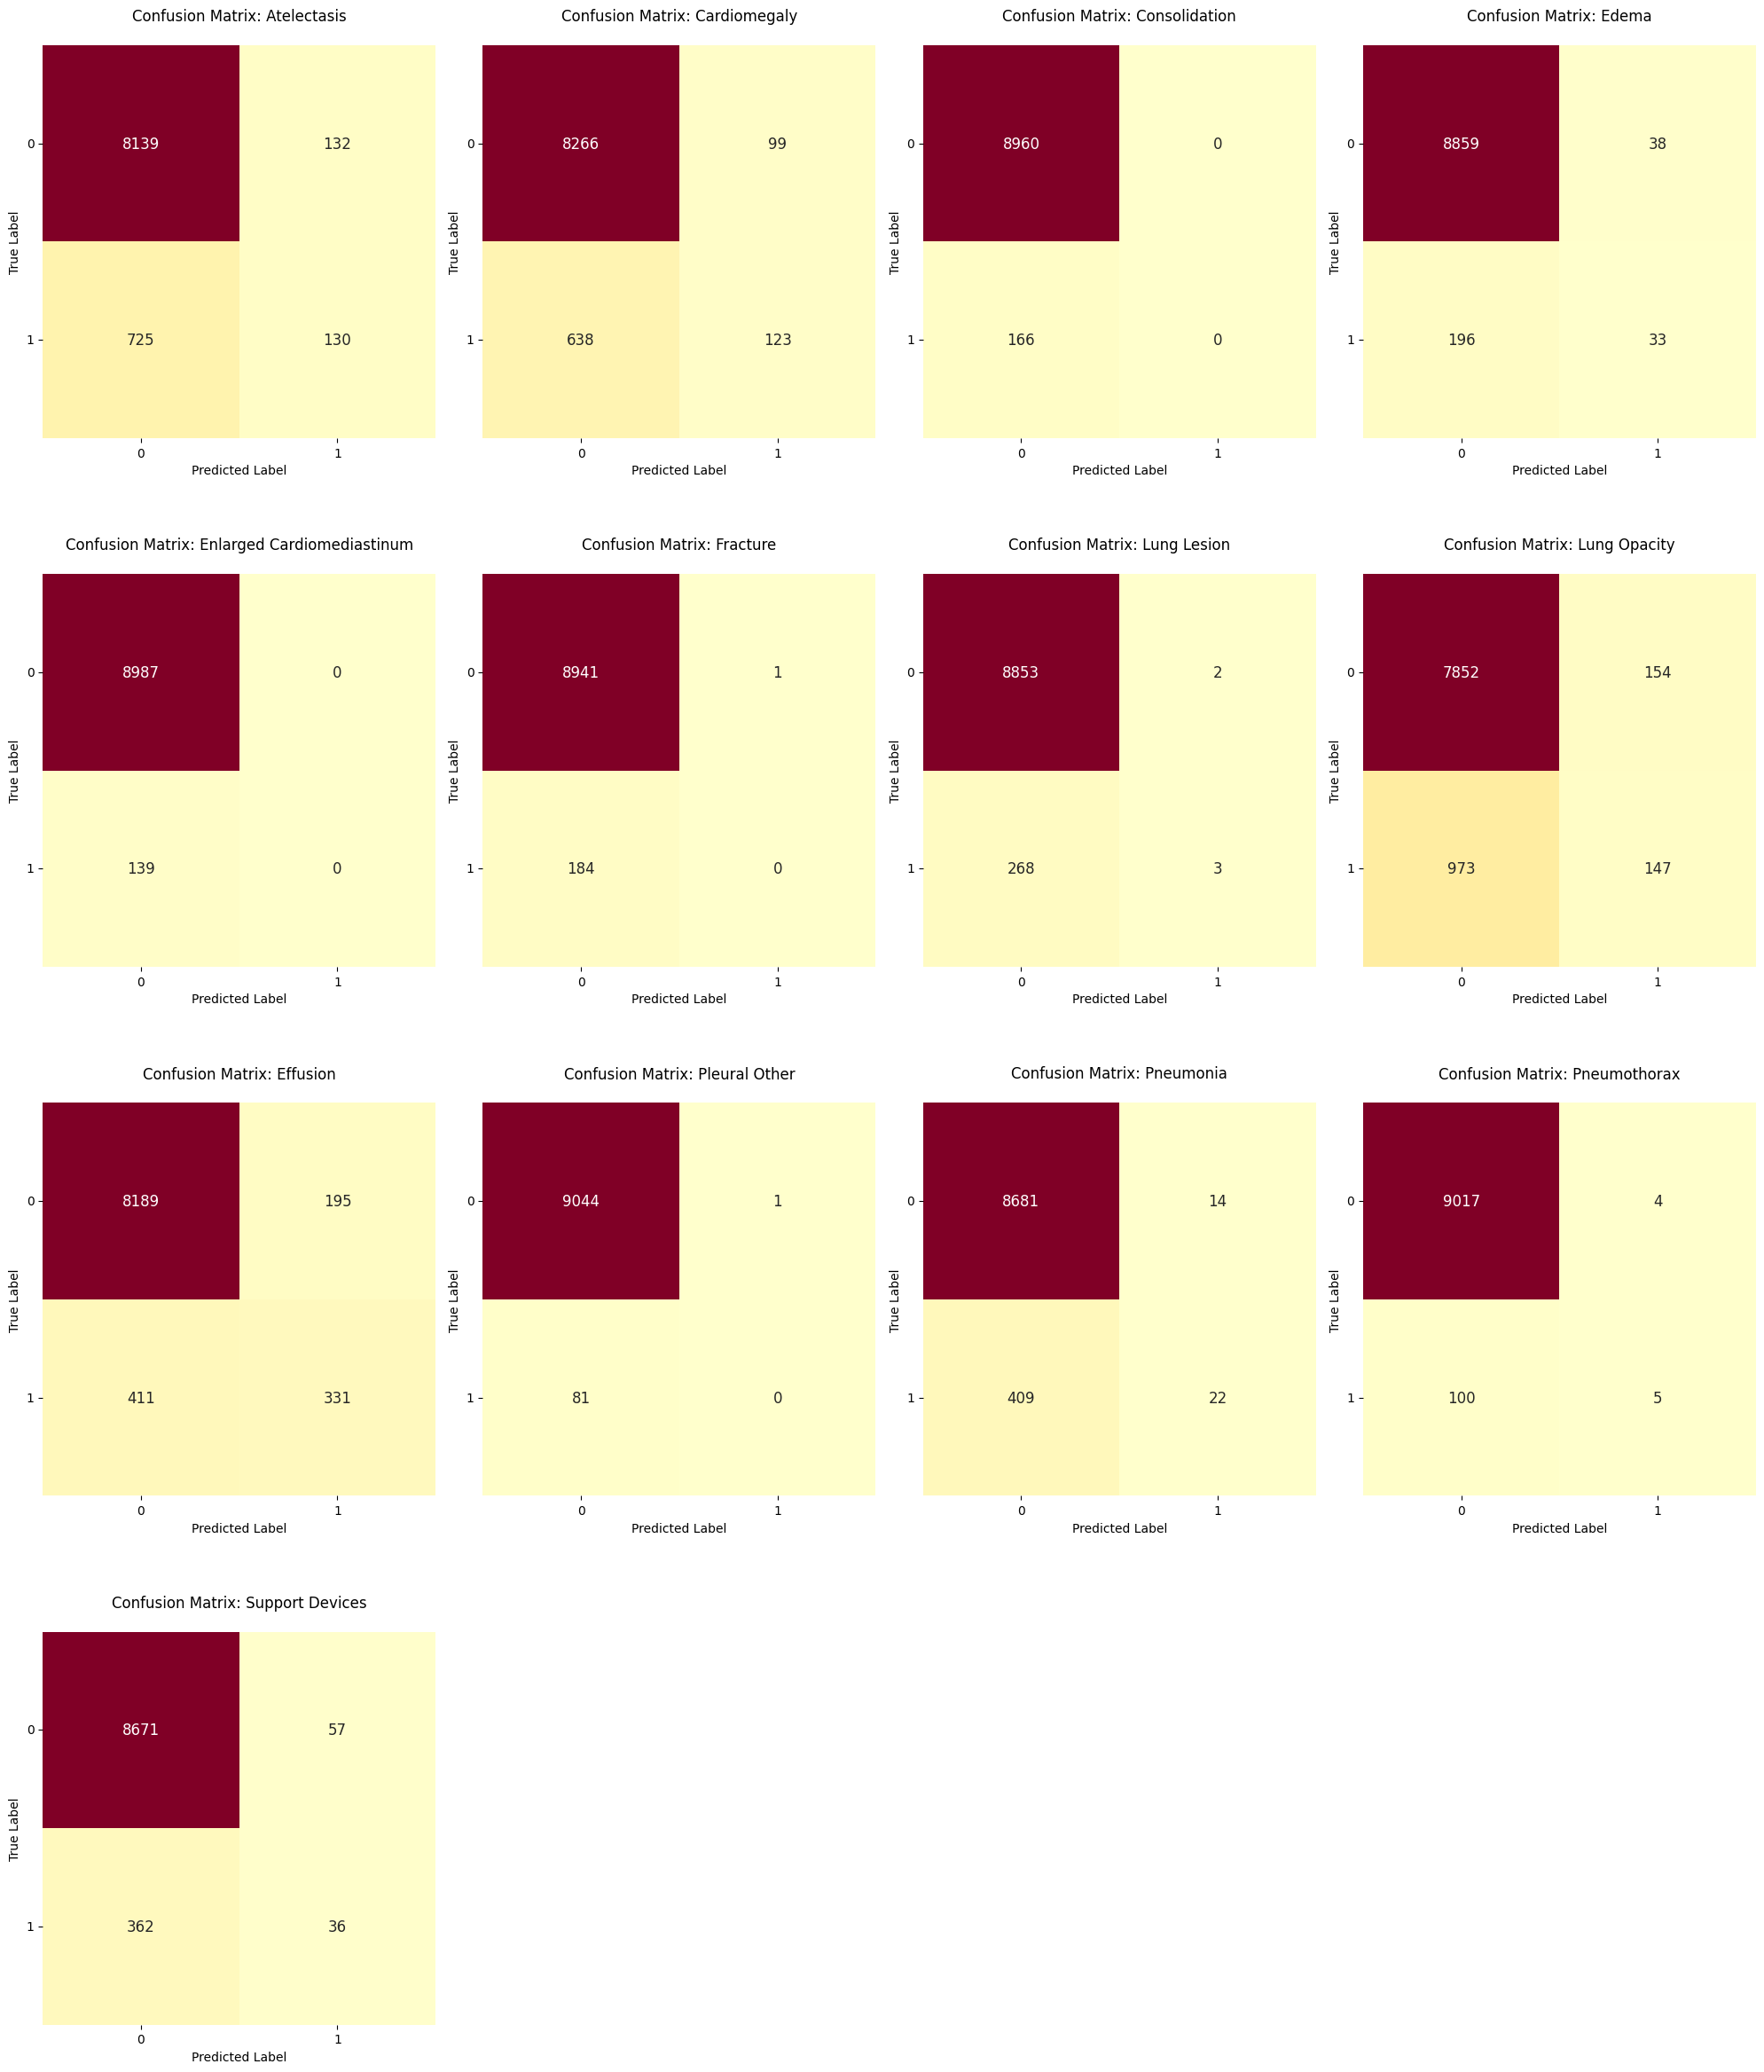

                            precision    recall  f1-score   support

               Atelectasis       0.50      0.15      0.23       855
              Cardiomegaly       0.55      0.16      0.25       761
             Consolidation       0.00      0.00      0.00       166
                     Edema       0.46      0.14      0.22       229
Enlarged Cardiomediastinum       0.00      0.00      0.00       139
                  Fracture       0.00      0.00      0.00       184
               Lung Lesion       0.60      0.01      0.02       271
              Lung Opacity       0.49      0.13      0.21      1120
                  Effusion       0.63      0.45      0.52       742
             Pleural Other       0.00      0.00      0.00        81
                 Pneumonia       0.61      0.05      0.09       431
              Pneumothorax       0.56      0.05      0.09       105
           Support Devices       0.39      0.09      0.15       398

                 micro avg       0.54      0.1

In [18]:
validate_model(model_train,test_dataset,x_test,y_test)